# 1. Call center data set — exponential likelihood with a gamma prior. 

Our model:

- The expected call rate (number of calls per minute) $\lambda$ is unknown and is assumed to come from a gamma prior.

$$\lambda \sim \text{Gamma}(\alpha=1, \beta=.25)$$
$$d_i \sim \text{Exponential}({\lambda}), \qquad i=1,2,\ldots \text{len(waiting_times_per_hour[13])} $$

In [25]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)


Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [3]:
# Plot histogram of waiting times for hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]


In [4]:
data = {
    'num' : len(waiting_times_hour),
    'waittime' : waiting_times_hour,
    'alpha': 1 ,
    'beta': .25
}

In [5]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num;  // number of data in the data set
    real<lower=0> waittime[num];  // durations in the data set
    //int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> lambda;  // expected call rate (number of calls per minute) - the
                              // parameter of the exponential likelihood  
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    lambda ~ gamma(alpha, beta);  // prior over lambda
    for(i in 1:num) {
        waittime[i] ~ exponential(lambda);  // likelihood function
    }
}
"""

In [6]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08d45e020a717e91b6ac5de00adf0e99 NOW.


In [9]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results = stan_model.sampling(data=data)

In [10]:
# summarize the results
print(stan_results.stansummary(pars=['lambda'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_08d45e020a717e91b6ac5de00adf0e99.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     1%    99%  n_eff   Rhat
lambda   6.34  9.4e-3   0.33   5.57   7.16   1234    1.0

Samples were drawn using NUTS at Fri Oct 18 00:08:41 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


So the interval is $[5.61, 7.1]$

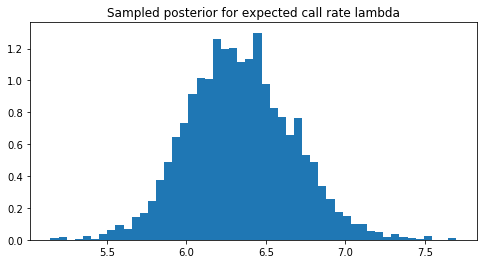

Posterior 98% interval over lambda: [5.5730811  7.15820897]


In [11]:
samples = stan_results.extract()

plt.figure(figsize=(8,4))
plt.hist(samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior for expected call rate lambda')
plt.show()

print('Posterior 98% interval over lambda:', np.percentile(samples['lambda'], [1, 99]))


# 2. Normal likelihood with normal-inverse-gamma prior.

Our model: 

Mean $x$ and variance $\sigma^2$ are unknown and are assumed to come from a normal-inverse-gamma prior. 

$$(x,\sigma^2) \sim \text{Normal-inverse-gamma}(\mu, \nu, \alpha, \beta) $$
$$d_i \sim \text{Normal}(x, \sigma^2) , \qquad i=1,2,\ldots 200$$

In [17]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(data), "data")

200 data


In [18]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num;  // number of data in the data set
    real dat[num];  // data in the data set
    real mu; // fixed prior hyperparameter
    real<lower=0> nu; // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x;  // mean , the parameter of the normal likelihood 
    real<lower=0> sigma2; // variance of the normal likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    sigma2 ~ inv_gamma(alpha, beta);  // sampling prior
    x ~ normal(mu, sqrt(sigma2/nu));            // parameters
    for (i in 1:num) {
        dat[i] ~ normal(x, sqrt(sigma2)); // likelihood
    }
}
"""

In [19]:
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller nu_0 is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # alpha and beta govern the marginal prior over the variance.
beta_0 = 0.4
stan_data = {
    'num': len(data),
    'mu': mu_0,
    'nu': nu_0,
    'alpha': alpha_0,
    'beta': beta_0,
    'dat': data 
}

In [20]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07be3fb1ec98d150d50dd15b41f4a8df NOW.


In [21]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results = stan_model.sampling(data=stan_data)

In [22]:
print(stan_results.stansummary(pars=['x','sigma2'], probs=[0.025, 0.975]))

Inference for Stan model: anon_model_07be3fb1ec98d150d50dd15b41f4a8df.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        3.06  2.4e-3   0.14    2.8   3.33   3389    1.0
sigma2   3.62  6.9e-3   0.36   2.96   4.42   2780    1.0

Samples were drawn using NUTS at Fri Oct 18 00:11:28 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


So the interval for mean is $[2.81, 3.33]$ and the interval for variance is $[2.99,4.39]$.

OrderedDict([('x', array([3.06645623, 3.08336395, 3.0622925 , ..., 3.33237467, 3.19200372,
       3.03525242])), ('sigma2', array([2.79821414, 3.50416344, 3.2132414 , ..., 3.47047127, 3.43112629,
       3.39261899])), ('lp__', array([-235.45541824, -232.25202106, -232.79180921, ..., -234.33521939,
       -232.77702486, -232.37720742]))])


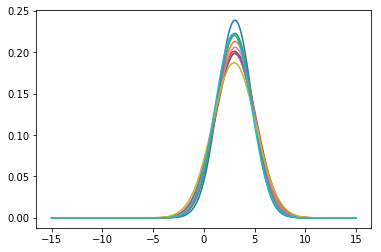

In [27]:
samples = stan_results.extract()
x = np.linspace(-15,15,1000)
print(samples)
params = []
for i in range(10):
    params.append((samples['x'][i], samples['sigma2'][i]))

for x_, sigma2_ in params:
    plt.plot(x,sts.norm.pdf(x,loc=x_,scale=np.sqrt(sigma2_)))


# Log-normal HRTEM data. 

In [28]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

500 data, min: 1.051827, max: 28.942578


In [29]:
log_data = np.log(data)

In [30]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num;  // number of data in the data set
    real dat[num];  // data in the data set
    real mu; // fixed prior hyperparameter
    real<lower=0> nu; // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x;  // mean , the parameter of the normal likelihood 
    real<lower=0> sigma2; // variance of the normal likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    sigma2 ~ inv_gamma(alpha, beta);  // sampling prior
    x ~ normal(mu, sqrt(sigma2/nu));            // parameters
    for (i in 1:num) {
        dat[i] ~ normal(x, sqrt(sigma2)); // likelihood
    }
}
"""

In [31]:
mu_0 = 2.3
nu_0 = 0.1
alpha_0 = 2
beta_0 = 5

stan_data = {
    'num': len(log_data),
    'dat': log_data,
    'mu': mu_0,
    'nu': nu_0,
    'alpha': alpha_0,
    'beta': beta_0
}

In [32]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07be3fb1ec98d150d50dd15b41f4a8df NOW.


In [33]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results = stan_model.sampling(data=stan_data)

In [35]:
print(stan_results.stansummary(pars=['x','sigma2'], probs=[0.025, 0.975]))

Inference for Stan model: anon_model_07be3fb1ec98d150d50dd15b41f4a8df.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        1.89  5.6e-4   0.03   1.83   1.95   3053    1.0
sigma2    0.5  5.4e-4   0.03   0.44   0.56   3268    1.0

Samples were drawn using NUTS at Fri Oct 18 00:20:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


OrderedDict([('x', array([1.91042388, 1.87623156, 1.84828762, ..., 1.88149579, 1.87742663,
       1.86802198])), ('sigma2', array([0.47497854, 0.49496087, 0.53540694, ..., 0.46515543, 0.51119739,
       0.47297765])), ('lp__', array([-75.36191988, -75.15007054, -76.76554564, ..., -75.51147448,
       -75.29133355, -75.54768446]))])


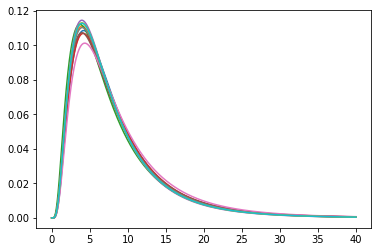

In [42]:
samples = stan_results.extract()
x = np.linspace(0,40,1000)
print(samples)
params = []
for i in range(10):
    params.append((samples['x'][i], samples['sigma2'][i]))

for x_, sigma2_ in params:
    plt.plot(x,sts.lognorm.pdf(x, np.sqrt(sigma2_), scale=np.exp(x_)))
